In [89]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from math import sqrt

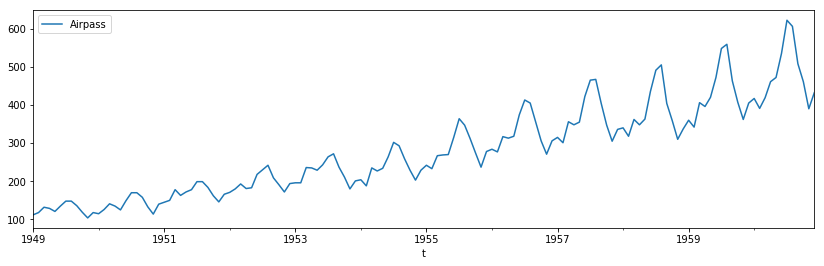

In [2]:
AirPassengers = pd.read_csv("Data/AirPassengers.csv", parse_dates=[0], dayfirst=True, index_col="t")
AirPassengers.plot(y="Airpass", figsize=(14,4))

x = AirPassengers
y = np.log(AirPassengers)

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing

les = ExponentialSmoothing(np.asarray(y['Airpass']), trend=None, seasonal=None).fit()
les_pred = les.forecast(12)

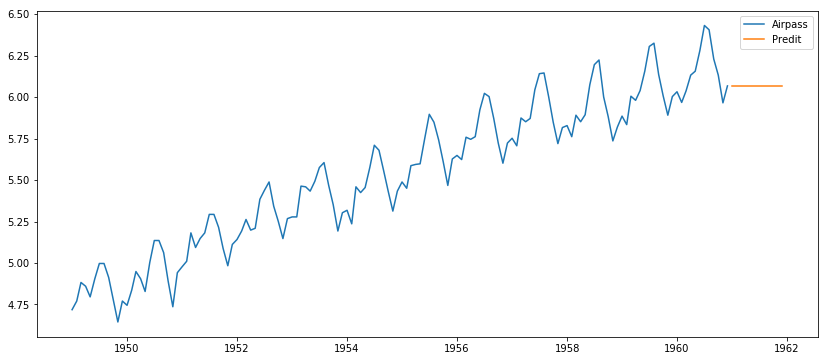

In [24]:
plt.figure(figsize=(14,6))
plt.plot(y['Airpass'], label='Airpass')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), les_pred, label='Predit')
plt.legend()
plt.show()

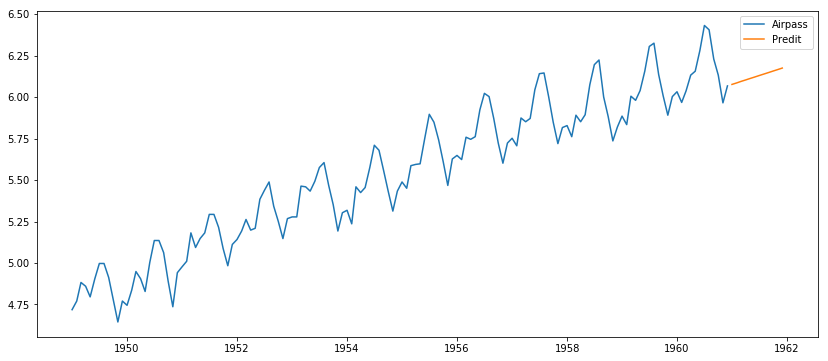

In [32]:
led = ExponentialSmoothing(np.asarray(y['Airpass']), trend='mul', seasonal=None).fit()
led_pred = led.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y['Airpass'], label='Airpass')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), led_pred, label='Predit')
plt.legend()
plt.show()

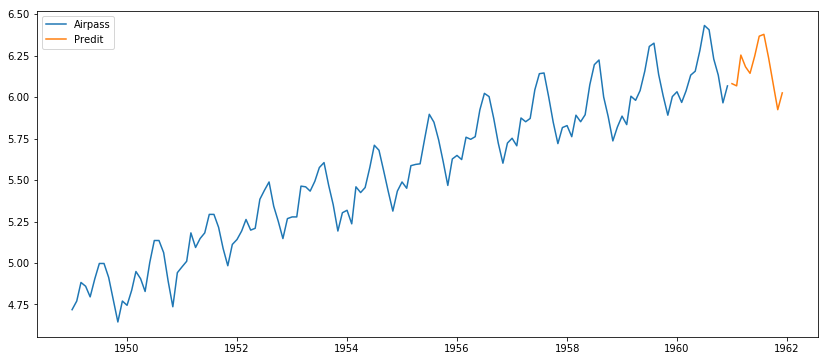

In [40]:
hw = ExponentialSmoothing(np.asarray(y['Airpass']), seasonal_periods=12, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y['Airpass'], label='Airpass')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.legend()
plt.show()

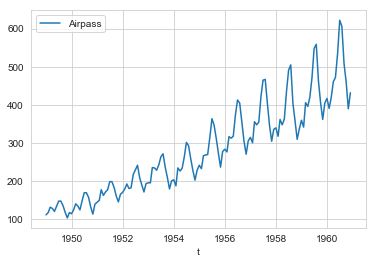

In [32]:
# temp serie
sns.lineplot(data=x)

We see there is a multiplicative seasonality. Let's use the log version to turn it to an additive seasonnality.

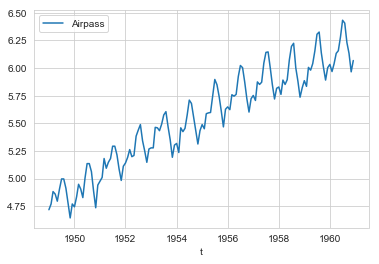

In [33]:
# log version of the temp serie
sns.lineplot(data=y)

Let's check if it is a stationnary process by plotting the auto-correlation function and see if translations have no effects on it.

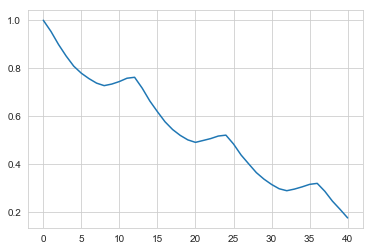

In [56]:
from statsmodels.tsa.stattools import acf

plt.plot(acf(y))

The ACF is slowly decreasing to 0 so it is non-stationnar. Let's first use the differentiation $(I-B)$

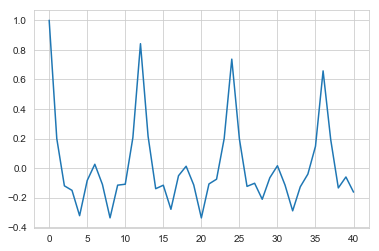

In [81]:
from statsmodels.tsa.statespace.tools import diff

y_dif1 = diff(y,k_diff=1)
plt.plot(acf(y_dif1))

There is still a decrease. Let's differentiate by $(I-B^{12})$ to differentiate on the seasonnality 12

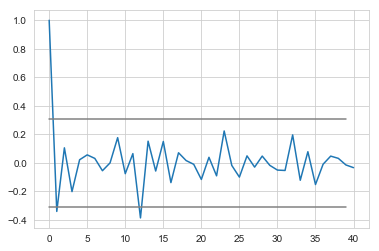

In [96]:
y_dif2 = diff(y,k_diff=1,k_seasonal_diff=1,seasonal_periods=12)
plt.plot(acf(y_dif2))
plt.plot(np.ones(40)*1.96/sqrt(40),color='gray')
plt.plot(np.ones(40)*-1.96/sqrt(40),color='gray')

That seems ok. The auto-correlations of the residuals are all in the interval $[-1.96/sqrt(n),1.96/sqrt(n)]$ so they are independant gaussian white noise. We could have also done the Portemanteau test.

To summarize, we identified an ARMA model on the serie: $(I-B)(I-B^{12})ln(X_t)$

Let's identify, estimate and validate the models by using the autocorrelogrammes simples and partials estimated:

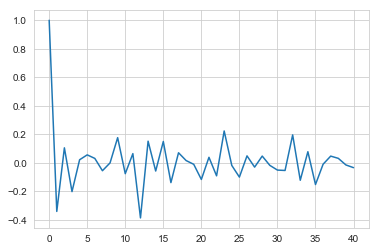

In [85]:
#simples autocorrelogrammes
plt.plot(acf(y_dif2))

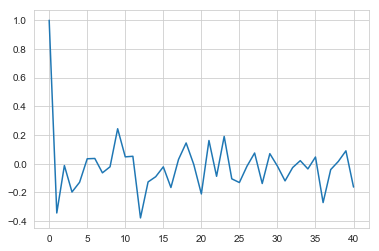

In [86]:
from statsmodels.tsa.stattools import pacf

# partials autocorrélogrames
plt.plot(pacf(y_dif2))

Looking at the acf and dacf, let's try a $SARIMA(1,1,1)(1,1,1)_{12}$ model

$(I−φ_1B)(I−φ′_1B^{12})(I−B)(I−B^{12})ln(X_t) = (I+θ_1B)(I+θ′_1B^{12}) ε_t$

In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model1 = SARIMAX(y,order=[1,1,1],seasonal_order=[1,1,1,12])
model1.fit().summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            Airpass   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Sun, 05 May 2019   AIC                           -480.303
Time:                                    19:04:14   BIC                           -465.927
Sample:                                01-01-1949   HQIC                          -474.461
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1724      0.212      0.814      0.416      -0.243       0.587
ma.L1         -0.5675      0.183     -3.099      0.002      -0.926      -0.209
ar.S.L12      -0.0985      0.197     -0.499      0.617      -0.485       0.288
ma.S.L12      -0.4980      0.210     -2.370      0.018      -0.910      -0.086
sigma2         0.0013      0.000      8.449      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.00   Jarque-Bera (JB):                 3.55
Prob(Q):                              0.61   Prob(JB):                         0.17
Heteroskedasticity (H):               0.61   Skew:                            -0.01
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
model1.fit().tvalues

ar.L1       0.814042
ma.L1      -3.099254
ar.S.L12   -0.499427
ma.S.L12   -2.369649
sigma2      8.448531
dtype: float64

In [115]:
model1.fit().pvalues

ar.L1       4.156208e-01
ma.L1       1.940084e-03
ar.S.L12    6.174789e-01
ma.S.L12    1.780498e-02
sigma2      2.949907e-17
dtype: float64